### IE801(B) Logistics Management HW2

- Lee Kanghoon, 20203421

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy

import gurobipy as gp
from gurobipy import GRB
from itertools import product

### Problem 1 : Generate TSP instances of n=20, 50, 100 randomly.

    
- generate_instance
    - 도시의 갯수를 받아서 그에 따른 정수 기반 위치를 반환.
    
    
- visualize_points
    - 도시들의 (x, y) 좌표를 받아서 visualize
    - tour path도 넘겨주면 그에 따른 path도 visualize.

In [2]:
def generate_instance(num_nodes, out_type=None):
    x = np.random.randint(100, size=num_nodes)
    y = np.random.randint(100, size=num_nodes)
    if out_type:
        return x.astype(out_type), y.astype(out_type)
    return x, y

In [3]:
def visualize_points(x, y, title=None, tour=None):

    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    
    plt.xticks([])
    plt.yticks([])
    
    if title:
        plt.title(title)
    
    if tour is None:
        plt.scatter(x, y)
    else:
        plt.plot(x[tour], y[tour], marker='o')
        
    plt.show()
    plt.close('all')

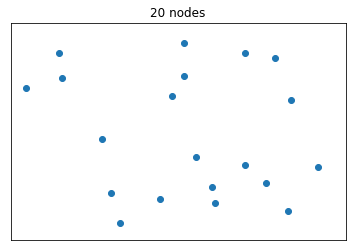

In [34]:
x, y = generate_instance(20)
visualize_points(x, y, "20 nodes")

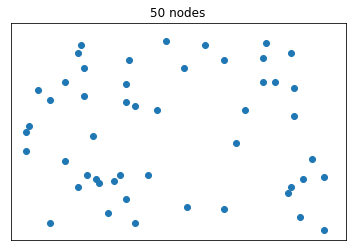

In [35]:
x, y = generate_instance(50)
visualize_points(x, y, "50 nodes")

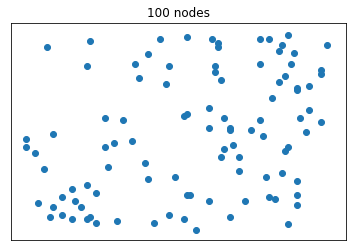

In [36]:
x, y = generate_instance(100)
visualize_points(x, y, "100 nodes")

### Problem 2 : Solve the problems using Gurobi and lazy constraints.

![nn](./Images/HW2_image1.png)

Reference : https://www.gurobi.com/documentation/9.1/examples/tsp_py.html

- get_cost
    - 도시들의 (x, y) 좌표를 받아서 i 도시에서 j 도시까지의 거리를 계산한 numpy array를 반환.
    
    
- subtourelim
    - TSP MILP 문제를 풀다가 solution을 찾게 되면 call 되는 function. 
    - subtour의 존재여부를 파악한 뒤, 만약 존재하면 subtour를 제거할 수 있도록 그에 맞는 constraint (2.11) 를 추가.
    - lazy constraint가 적용되는 부분.
    
    
- subtour
    - edge들간의 연결관계를 받아서, 가장 작은 subtour를 반환.
    
    
- solve_TSP
    - 도시들의 (x, y) 좌표를 받아서 minimum cost tour path를 반환. 
    - solve TSP MILP with gurobi.
    - (2.8), (2.9), (2.10), (2.12) 식이 구현되어 있음.

In [5]:
def get_cost(x, y, integer=False):
    
    x_ = x.copy().reshape(-1, 1)
    y_ = y.copy().reshape(-1, 1)
    cost = np.sqrt((x - x_) ** 2 + (y - y_) ** 2)

    if integer:
        return np.round(cost, 0).astype(dtype=np.int64)
    else:
        return cost

In [6]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys() if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        n = int(model.ModelName)
        tour = subtour(selected, n)
        
        if len(tour) < n:
            out_nodes = list(set(range(n)) - set(tour))
            in_nodes = tour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in product(out_nodes, in_nodes)) >= 1)

In [7]:
def subtour(edges, n):
    unvisited = list(range(n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*') if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [37]:
def Gurobi_solve_TSP(x, y):
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    
    model = gp.Model(name=str(num_nodes))
    model.Params.LogToConsole = 0
    variables = gp.tupledict()

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                variables[i, j] = model.addVar(obj=cost[i][j], vtype=GRB.BINARY, name=str(num_nodes))

    for i in range(num_nodes):
        temp_list = list(range(num_nodes))
        temp_list.pop(i)
        model.addConstr(sum(variables[i, j] for j in temp_list) == 1)
        model.addConstr(sum(variables[j, i] for j in temp_list) == 1)

    model._vars = variables
    model.Params.lazyConstraints = 1
    model.optimize(subtourelim)

    vals = model.getAttr('x', variables)
    selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

    tour = subtour(selected, num_nodes)
    assert len(tour) == num_nodes
    
    tour = tour + [0]
    return tour, model.objVal

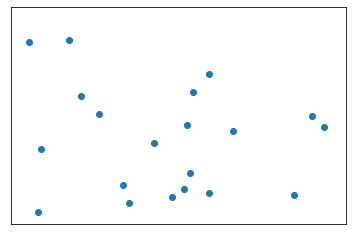

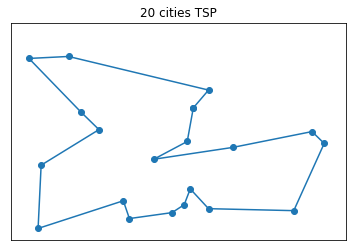

In [38]:
x, y = generate_instance(20)
tour, cost = Gurobi_solve_TSP(x, y)

visualize_points(x, y)
visualize_points(x, y, '20 cities TSP', tour)

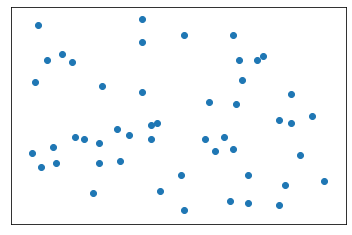

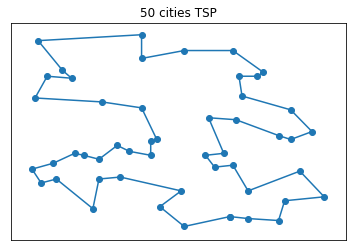

In [11]:
x, y = generate_instance(50)
tour, cost = Gurobi_solve_TSP(x, y)

visualize_points(x, y)
visualize_points(x, y, '50 cities TSP', tour)

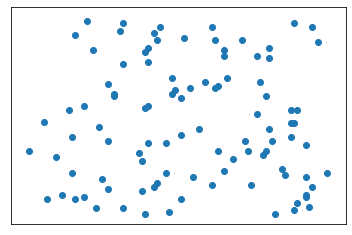

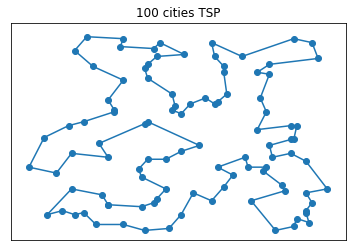

In [12]:
x, y = generate_instance(100)
tour, cost = Gurobi_solve_TSP(x, y)

visualize_points(x, y)
visualize_points(x, y, '100 cities TSP', tour)

### Problem 3 : Solve the problems using the Concorde and LKH solvers.

In [13]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [31]:
%julia using PyCall

%julia using Concorde
%julia using LKH

In [15]:
num_nodes = 100
x, y = generate_instance(num_nodes, np.float64)

In [32]:
%%julia

x = py"""x"""
y = py"""y"""
opt_tour, opt_len = Concorde.solve_tsp(x, y; dist="EUC_2D")
println("solved with Concorde!")

solved with Concorde!

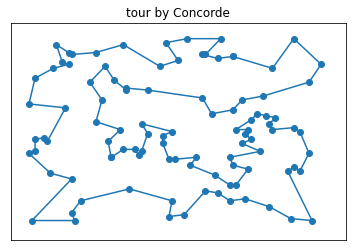

In [25]:
tour = %julia opt_tour
tour = np.append(tour - 1, [0])

visualize_points(x, y, "tour by Concorde", tour)

In [33]:
%%julia

x = py"""x"""
y = py"""y"""
opt_tour, opt_len = LKH.solve_tsp(x, y; dist="EUC_2D")
println("solved with LKH!")


solved with LKH!

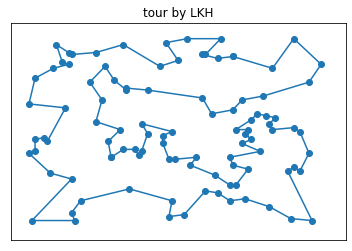

In [29]:
tour = %julia opt_tour
tour = np.append(tour - 1, [0])

visualize_points(x, y, "tour by LKH", tour)

### Problem 4 : Implement the following heuristic algorithms to solve the problems

- Nearest Neighbor

- Greedy Algorithm

- Nearest Insertion

- Farthest Insertion

- Christofides

- 2-opt Exchange